# ML Aplicada - Previsão da sobrevivência de pacientes hospitalares

Os preditores de mortalidade intra-hospitalar para pacientes internados permanecem pouco caracterizados, e precisam ser compreendidos. O objetivo com esse banco de dados é desenvolver e validar um modelo de predição para mortalidade hospitalar por todas as causas entre pacientes internados.

Neste conjunto de dados, existem vários fatores que estão envolvidos quando um paciente é hospitalizado. Com base nesses fatores, iremos realizar a previsão se o paciente sobreviverá ou não.

In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1_9EVNjitAF97lwU9CxX-fIqMkUC8KZIf

Downloading...
From: https://drive.google.com/uc?id=1_9EVNjitAF97lwU9CxX-fIqMkUC8KZIf
To: /content/dataset.csv
100% 31.4M/31.4M [00:00<00:00, 67.9MB/s]


In [ ]:
!pip install scipy==1.11.4

In [ ]:
!pip install scikit-plot

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)

%matplotlib inline

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# from scipy.stats import loguniform

from sklearn.model_selection import train_test_split, GridSearchCV
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import (accuracy_score,
                            classification_report,
                            roc_auc_score, roc_curve, auc, precision_recall_curve,
                            confusion_matrix, f1_score, precision_score, recall_score)


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, KFold

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 250)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#  Carregamento e análise exploratória dos dados

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 500)

In [ ]:
raw_data = pd.read_csv("./dataset.csv")
raw_data.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,heart_rate_apache,intubated_apache,map_apache,resprate_apache,temp_apache,ventilated_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,92,admit,CTICU,0.541667,73.9,113.0,502.01,0,0.0,3.0,6.0,0.0,4.0,118.0,0.0,40.0,36.0,39.3,0.0,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,131.0,73.0,39.9,37.2,68.0,63.0,68.0,63.0,119.0,108.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,131.0,115.0,168.0,109.0,4.0,3.4,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,90,admit,Med-Surg ICU,0.927778,70.2,108.0,203.01,0,0.0,1.0,3.0,0.0,1.0,120.0,0.0,46.0,33.0,35.1,1.0,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,159.0,67.0,36.3,35.1,61.0,48.0,61.0,48.0,114.0,100.0,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,95.0,71.0,145.0,128.0,4.2,3.8,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,95.3,122.0,703.03,0,0.0,3.0,6.0,0.0,5.0,102.0,0.0,68.0,37.0,36.7,0.0,88.0,48.0,88.0,48.0,96.0,68.0,102.0,68.0,102.0,68.0,21.0,8.0,98.0,91.0,148.0,105.0,148.0,105.0,37.0,36.7,88.0,58.0,88.0,58.0,96.0,78.0,91.0,83.0,91.0,83.0,20.0,16.0,98.0,91.0,148.0,124.0,148.0,124.0,NaN,NaN,NaN,NaN,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,92,admit,CTICU,0.000694,61.7,203.0,1206.03,1,0.0,4.0,6.0,0.0,5.0,114.0,1.0,60.0,4.0,34.8,1.0,48.0,42.0,48.0,42.0,116.0,92.0,84.0,84.0,84.0,84.0,23.0,7.0,100.0,95.0,158.0,84.0,158.0,84.0,38.0,34.8,62.0,44.0,NaN,NaN,100.0,96.0,92.0,71.0,NaN,NaN,12.0,11.0,100.0,99.0,136.0,106.0,NaN,NaN,185.0,88.0,5.0,3.5,0.04,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,NaN,119.0,601.01,0,0.0,NaN,NaN,NaN,NaN,60.0,0.0,103.0,16.0,36.7,0.0,99.0,57.0,99.0,57.0,89.0,60.0,104.0,90.0,104.0,90.0,18.0,16.0,100.0,96.0,147.0,120.0,147.0,120.0,37.2,36.7,99.0,68.0,99.0,68.0,89.0,76.0,104.0,92.0,104.0,92.0,NaN,NaN,100.0,100.0,130.0,120.0,130.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


In [ ]:
raw_data.shape

(91713, 85)

In [ ]:
raw_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

In [ ]:
raw_data.describe()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,heart_rate_apache,intubated_apache,map_apache,resprate_apache,temp_apache,ventilated_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,Unnamed: 83,hospital_death
count,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,88993.000000,90051.000000,90612.000000,91713.000000,90998.000000,89812.000000,89812.000000,90676.000000,89812.000000,90835.000000,90998.000000,90719.000000,90479.000000,87605.000000,90998.000000,91548.000000,91548.000000,90673.000000,90673.000000,91568.000000,91568.000000,91493.000000,91493.000000,90234.000000,90234.000000,91328.000000,91328.000000,91380.000000,91380.000000,91554.000000,91554.00000,90686.000000,90686.000000,89389.000000,89389.000000,88094.000000,88094.000000,84363.000000,84363.000000,88923.000000,88923.000000,87074.000000,87074.000000,82629.000000,82629.000000,87356.000000,87356.000000,87528.000000,87528.000000,88102.000000,88102.000000,84372.000000,84372.000000,85906.000000,85906.000000,82128.000000,82128.000000,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,0.0,91713.000000
mean,65606.079280,65537.131464,105.669262,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,84.028340,185.401739,558.216377,0.201106,0.027979,3.465049,5.471195,0.009528,3.994778,99.707932,0.151223,88.015873,25.811007,36.414472,0.325721,88.491873,50.161314,88.610513,50.242597,103.000568,70.321848,104.651339,64.871859,104.590454,64.941541,28.882774,12.846279,99.241836,90.454826,148.339745,96.92387,148.235549,96.993313,37.284201,36.268391,75.354508,62.838150,75.805934,63.270616,92.229198,83.663720,91.612950,79.400028,91.594126,79.709315,22.633614,17.211525,98.044637,95.174310,133.247395,116.362296,133.054686,116.549625,174.638023,114.380940,4.251594,3.934658,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638,NaN,0.086302
std,37795.088538,37811.252183,62.854406,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,25.011497,86.050882,463.266985,0.400829,0.164912,0.951715,1.288376,0.097148,1.560166,30.870502,0.358268,42.032412,15.106312,0.833496,0.468646,19.798379,13.317586,19.793743,13.341521,22.017346,17.115903,20.808358,15.679680,20.701171,15.701305,10.701973,5.064943,1.794181,10.030069,25.733259,20.67793,25.792453,20.705016,0.693287,0.745147,18.409190,16.363229,18.481826,16.422063,21.823704,20.279869,20.533174,19.130590,20.552018,19.236507,7.515043,6.072588,3.212934,6.625227,27.556986,26.510637,27.679751,26.623528,86.687955,38.273013,0.667355,0.579610,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169,NaN,0.280811
min,1.000000,1.000000,2.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,38.600000,101.000000,0.010000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,30.000000,0.000000,40.000000,4.000000,32.

In [ ]:
#raw_data.isnull().sum(axis=0).sort_values(ascending=False)
pd.DataFrame(round(raw_data.isnull().sum()*100/len(raw_data),2).sort_values(ascending=False))

,0
Unnamed: 83,100.00
d1_potassium_max,10.45
d1_potassium_min,10.45
h1_mbp_noninvasive_min,9.90
h1_mbp_noninvasive_max,9.90
apache_4a_hospital_death_prob,8.67
apache_4a_icu_death_prob,8.67
h1_diasbp_noninvasive_min,8.01
h1_diasbp_noninvasive_max,8.01
h1_sysbp_noninvasive_min,8.00


In [ ]:
pd.DataFrame(round(raw_data.nunique()*100/len(raw_data),4).sort_values(ascending=False))

,0
encounter_id,100.0000
patient_id,100.0000
bmi,38.0404
pre_icu_los_days,10.6386
weight,3.7170
d1_glucose_max,0.5866
height,0.4372
apache_3j_diagnosis,0.4351
d1_glucose_min,0.2791
icu_id,0.2628


Vamos listar colunas que possuem todos os valores iguais, ou todos diferentes (ids).

In [ ]:
nunique_train=raw_data.nunique().reset_index()
remove_col=nunique_train[(nunique_train[0]==len(raw_data)) | (nunique_train[0]==0) | (nunique_train[0]==1)]['index'].tolist()
remove_col

['encounter_id', 'patient_id', 'Unnamed: 83']

Atributos que podem ser descartados: **'Unnamed:83', 'encounter_id' e 'patient_id'**


Observe a quantidade de valores ausentes em cada linha...
Decidimos um valor limite para excluir alguns dos atributos do conjunto de dados (25k nesta abordagem).

In [ ]:
raw_data=raw_data.drop(remove_col,axis=1)
raw_data.head()

,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,heart_rate_apache,intubated_apache,map_apache,resprate_apache,temp_apache,ventilated_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,118,68.0,22.73,0,Caucasian,M,180.3,Floor,92,admit,CTICU,0.541667,73.9,113.0,502.01,0,0.0,3.0,6.0,0.0,4.0,118.0,0.0,40.0,36.0,39.3,0.0,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,131.0,73.0,39.9,37.2,68.0,63.0,68.0,63.0,119.0,108.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,131.0,115.0,168.0,109.0,4.0,3.4,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
1,81,77.0,27.42,0,Caucasian,F,160.0,Floor,90,admit,Med-Surg ICU,0.927778,70.2,108.0,203.01,0,0.0,1.0,3.0,0.0,1.0,120.0,0.0,46.0,33.0,35.1,1.0,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,159.0,67.0,36.3,35.1,61.0,48.0,61.0,48.0,114.0,100.0,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,95.0,71.0,145.0,128.0,4.2,3.8,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
2,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,95.3,122.0,703.03,0,0.0,3.0,6.0,0.0,5.0,102.0,0.0,68.0,37.0,36.7,0.0,88.0,48.0,88.0,48.0,96.0,68.0,102.0,68.0,102.0,68.0,21.0,8.0,98.0,91.0,148.0,105.0,148.0,105.0,37.0,36.7,88.0,58.0,88.0,58.0,96.0,78.0,91.0,83.0,91.0,83.0,20.0,16.0,98.0,91.0,148.0,124.0,148.0,124.0,NaN,NaN,NaN,NaN,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
3,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,92,admit,CTICU,0.000694,61.7,203.0,1206.03,1,0.0,4.0,6.0,0.0,5.0,114.0,1.0,60.0,4.0,34.8,1.0,48.0,42.0,48.0,42.0,116.0,92.0,84.0,84.0,84.0,84.0,23.0,7.0,100.0,95.0,158.0,84.0,158.0,84.0,38.0,34.8,62.0,44.0,NaN,NaN,100.0,96.0,92.0,71.0,NaN,NaN,12.0,11.0,100.0,99.0,136.0,106.0,NaN,NaN,185.0,88.0,5.0,3.5,0.04,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
4,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,NaN,119.0,601.01,0,0.0,NaN,NaN,NaN,NaN,60.0,0.0,103.0,16.0,36.7,0.0,99.0,57.0,99.0,57.0,89.0,60.0,104.0,90.0,104.0,90.0,18.0,16.0,100.0,96.0,147.0,120.0,147.0,120.0,37.2,36.7,99.0,68.0,99.0,68.0,89.0,76.0,104.0,92.0,104.0,92.0,NaN,NaN,100.0,100.0,130.0,120.0,130.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,0


In [ ]:
print("Número de registros com dados faltantes:", raw_data.isnull().any(axis=1).sum())
print("Número de atributos com dados faltantes:", raw_data.isnull().any(axis=0).sum())

Número de registros com dados faltantes: 34778
Número de atributos com dados faltantes: 74


Agora vamos remover os atributos do tipo "ID"

In [ ]:
raw_data.drop(['icu_admit_source', 'icu_id', 'icu_stay_type', 'hospital_id'],
              axis=1, inplace = True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            87485 non-null  float64
 1   bmi                            88284 non-null  float64
 2   elective_surgery               91713 non-null  int64  
 3   ethnicity                      90318 non-null  object 
 4   gender                         91688 non-null  object 
 5   height                         90379 non-null  float64
 6   icu_type                       91713 non-null  object 
 7   pre_icu_los_days               91713 non-null  float64
 8   weight                         88993 non-null  float64
 9   apache_2_diagnosis             90051 non-null  float64
 10  apache_3j_diagnosis            90612 non-null  float64
 11  apache_post_operative          91713 non-null  int64  
 12  arf_apache                     90998 non-null 

In [ ]:
pd.DataFrame(raw_data.nunique())

,0
age,74
bmi,34888
elective_surgery,2
ethnicity,6
gender,2
height,401
icu_type,8
pre_icu_los_days,9757
weight,3409
apache_2_diagnosis,44


*Removendo valores ausentes de algumas das colunas inter-relacionadas (bmi, weight and height)*

Reduzimos quase 3.000 instâncias com esse processo

In [ ]:
print(raw_data.shape)

(91713, 78)


In [ ]:
raw_data = raw_data[raw_data[['bmi', 'weight', 'height']].isna().sum(axis=1) == 0]
print(raw_data.shape)

(88284, 78)


### Análise univariada-multivariada

Gráficos individuais raramente não ajudam em grandes conjuntos de dados, nesta abordagem vamos ver a variação de instâncias de acordo com cada contexto da coluna.


A taxa de mortalidade para pacientes do sexo masculino-feminino é mostrada abaixo. Embora a taxa de **<span style="color: deeppink;"> mortes femininas</span>** seja **<span style="color: red;"> maior </span>** a pessoa mais jovem a falecer durante um dos casos era um **<span style="color: royalblue;">Homem</span>** de **16 anos** de idade.

In [ ]:
fig = px.histogram(raw_data[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death",
                   color="gender", marginal="box",
                   hover_data=raw_data[['age','gender','hospital_death','bmi']].columns)
fig.show()

This cell output is too large and can only be displayed while logged in.


**<span style="color: Midnightblue;"> Probabilidade média de morte hospitalar de pacientes</span>**
*com base na idade e sexo*

In [ ]:
age_death_F=raw_data[raw_data['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=raw_data[raw_data['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()

from plotly.subplots import make_subplots

fig = make_subplots()
fig.add_trace(
    go.Scatter(x=age_death_F['age'], y=age_death_F['hospital_death'], name="Pacientes Femininos"))
fig.add_trace(
    go.Scatter(x=age_death_M['age'], y=age_death_M['hospital_death'],name="Pacientes Masculinos"))
fig.update_layout(
    title_text="<b>Média de óbito hospitalar de pacientes por idade<b>")
fig.update_xaxes(title_text="<b>Idade do paciente<b>")
fig.update_yaxes(title_text="<b>Morte Hospitalar Média</b>", secondary_y=False)
fig.show()

**<span style="color: Midnightblue;"> Impactos do BMI (IMC) e peso sobre os pacientes</span>**

In [ ]:
weight_df=raw_data[['weight','hospital_death','bmi']]
weight_df['weight']=weight_df['weight'].round(0)
weight_df['bmi']=weight_df['bmi'].round(0)

weight_death=weight_df[['weight','hospital_death']].groupby('weight').mean().reset_index()
bmi_death=weight_df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()

fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(
    go.Scatter(x=weight_death['weight'], y=weight_death['hospital_death'], name="Weight"),
   row=1, col=1
)
fig.add_trace(
    go.Scatter(x=bmi_death['bmi'], y=bmi_death['hospital_death'], name="BMI"),
    row=1, col=2
)
fig.update_layout(
    title_text="<b>Impactos do BMI (IMC) e peso sobre os pacientes<b>"
)
fig.update_yaxes(title_text="<b>Morte Hospitalar Média")
fig.show()

**<span style="color: Midnightblue;">Taxa de sobrevivência em diferentes tipos de UTI</span>**

*algumas enfermarias de UTI têm maior probabilidade de morte por serem enfermarias cirúrgicas*

In [ ]:
ICU_type=raw_data[['icu_type','age','hospital_death']]


ICU_df=ICU_type.groupby(['icu_type','age']).mean().reset_index()
ICU_df['count']=ICU_type.groupby(['icu_type','age']).count().reset_index()['hospital_death']

fig = px.scatter(ICU_df, x="age", y="hospital_death", size="count", color="icu_type",
           hover_name="icu_type", log_x=False, size_max=60,)
fig.update_layout(
    title_text="<b>Taxa de sobrevivência em diferentes tipo de UTI<b>"
)
fig.update_yaxes(title_text="<b>Morte Hospitalar Média<b>")
fig.update_xaxes(title_text="<b>Idade<b>")
fig.show()

**Distribuição de densidade para atributos numéricos**

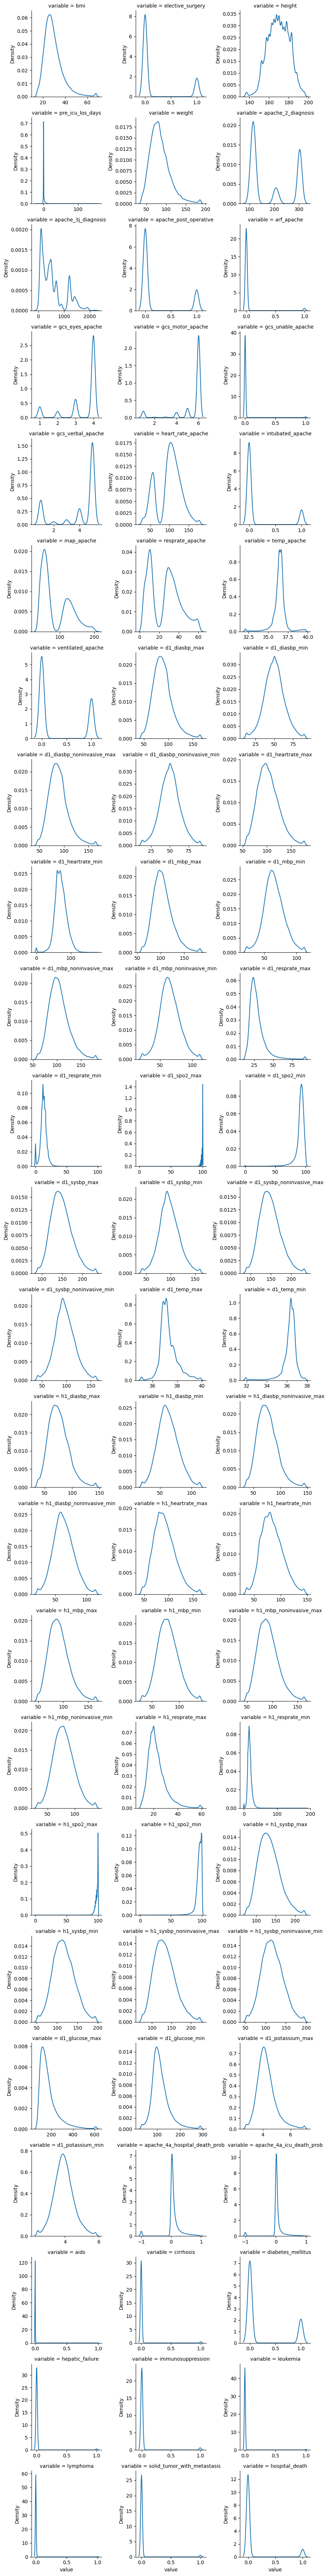

In [ ]:
unpivot = pd.melt(raw_data, raw_data.describe().columns[0], raw_data.describe().columns[1:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

# <center> 3. Pré-processamento dos dados

**Etapas:**

Conversão de valores categóricos;
Transformação de colunas numéricas e remoção de valores nulos;

Valores nulos para *categorias* são substituídos por **mode** e aqueles para *numéricos* são substituídos por **mean**

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88284 entries, 0 to 91712
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            84229 non-null  float64
 1   bmi                            88284 non-null  float64
 2   elective_surgery               88284 non-null  int64  
 3   ethnicity                      87073 non-null  object 
 4   gender                         88266 non-null  object 
 5   height                         88284 non-null  float64
 6   icu_type                       88284 non-null  object 
 7   pre_icu_los_days               88284 non-null  float64
 8   weight                         88284 non-null  float64
 9   apache_2_diagnosis             86718 non-null  float64
 10  apache_3j_diagnosis            87258 non-null  float64
 11  apache_post_operative          88284 non-null  int64  
 12  arf_apache                     87600 non-null  floa

In [ ]:
raw_data.nunique()[raw_data.nunique() == 2].index.tolist()

['elective_surgery',
 'gender',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'hospital_death']

In [ ]:
raw_data.select_dtypes(include='O').columns.values.tolist()

['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [ ]:
numerical_cat = [
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

categorical = ['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem',
 'apache_3j_diagnosis',
 'apache_2_diagnosis']


Converter tipo das variáveis binárias em número Inteiros (mantendo os valores faltantes)

In [ ]:
for col in numerical_cat:
    raw_data[col] = raw_data[col].astype('Int64')

raw_data.dtypes

,0
age,float64
bmi,float64
elective_surgery,Int64
ethnicity,object
gender,object
height,float64
icu_type,object
pre_icu_los_days,float64
weight,float64
apache_2_diagnosis,float64


Completar valores faltantes com a Moda.

In [ ]:
for col in numerical_cat:
    raw_data[col] = raw_data[col].fillna(raw_data[col].mode()[0])

In [ ]:
not_numeric = raw_data[numerical_cat + categorical + ['hospital_death']].columns.tolist()
print(not_numeric)
numeric_only = raw_data.drop(not_numeric,axis=1).columns.tolist()
print(numeric_only)

['elective_surgery', 'apache_post_operative', 'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'ethnicity', 'gender', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'apache_3j_diagnosis', 'apache_2_diagnosis', 'hospital_death']
['age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max

In [ ]:
raw_data[categorical].nunique()

,0
ethnicity,6
gender,2
icu_type,8
apache_3j_bodysystem,11
apache_2_bodysystem,10
apache_3j_diagnosis,398
apache_2_diagnosis,44


In [ ]:
from sklearn import preprocessing

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
categorical.remove('gender')
categorical.remove('apache_3j_diagnosis')
categorical.remove('apache_2_diagnosis')

In [ ]:
raw_data['gender'] = le.fit_transform(raw_data['gender'])
raw_data['apache_3j_diagnosis'] = le.fit_transform(raw_data['apache_3j_diagnosis'])
raw_data['apache_2_diagnosis'] = le.fit_transform(raw_data['apache_2_diagnosis'])

Usando o codificador ``one-hot`` devido à grande variedade de **valores exclusivos** nas categorias

In [ ]:
dummy_data = pd.get_dummies(raw_data,
    prefix='isin',
    prefix_sep='_',
    columns=categorical, # We will use a separate method for this cathegory
    drop_first=False)
dummy_data.reset_index(drop = True, inplace = True)
dummy_data

,age,bmi,elective_surgery,gender,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,heart_rate_apache,intubated_apache,map_apache,resprate_apache,temp_apache,ventilated_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,hospital_death,isin_African American,isin_Asian,isin_Caucasian,isin_Hispanic,isin_Native American,isin_Other/Unknown,isin_CCU-CTICU,isin_CSICU,isin_CTICU,isin_Cardiac ICU,isin_MICU,isin_Med-Surg ICU,isin_Neuro ICU,isin_SICU,isin_Cardiovascular,isin_Gastrointestinal,isin_Genitourinary,isin_Gynecological,isin_Hematological,isin_Metabolic,isin_Musculoskeletal/Skin,isin_Neurological,isin_Respiratory,isin_Sepsis,isin_Trauma,isin_Cardiovascular,isin_Gastrointestinal,isin_Haematologic,isin_Metabolic,isin_Neurologic,isin_Renal/Genitourinary,isin_Respiratory,isin_Trauma,isin_Undefined Diagnoses,isin_Undefined diagnoses
0,68.0,22.730000,0,1,180.3,0.541667,73.9,11,124,0,0,3.0,6.0,0,4.0,118.0,0,40.0,36.0,39.3,0,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,131.0,73.0,39.9,37.2,68.0,63.0,68.0,63.0,119.0,108.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,131.0,115.0,168.0,109.0,4.0,3.4,0.10,0.05,0,0,1,0,0,0,0,0,0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
1,77.0,27.420000,0,0,160.0,0.927778,70.2,7,49,0,0,1.0,3.0,0,1.0,120.0,0,46.0,33.0,35.1,1,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,159.0,67.0,36.3,35.1,61.0,48.0,61.0,48.0,114.0,100.0,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,95.0,71.0,145.0,128.0,4.2,3.8,0.47,0.29,0,0,1,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
2,25.0,31.950000,0,0,172.7,0.000694,95.3,20,167,0,0,3.0,6.0,0,5.0,102.0,0,68.0,37.0,36.7,0,88.0,48.0,88.0,48.0,96.0,68.0,102.0,68.0,102.0,68.0,21.0,8.0,98.0,91.0,148.0,105.0,148.0,105.0,37.0,36.7,88.0,58.0,88.0,58.0,96.0,78.0,91.0,83.0,91.0,83.0,20.0,16.0,98.0,91.0,148.0,124.0,148.0,124.0,NaN,NaN,NaN,NaN,0.00,0.00,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3,81.0,22.640000,1,0,165.1,0.000694,61.7,24,222,1,0,4.0,6.0,0,5.0,114.0,1,60.0,4.0,34.8,1,48.0,42.0,48.0,42.0,116.0,92.0,84.0,84.0,84.0,84.0,23.0,7.0,100.0,95.0,158.0,84.0,158.0,84.0,38.0,34.8,62.0,44.0,NaN,NaN,100.0,96.0,92.0,71.0,NaN,NaN,12.0,11.0,100.0,99.0,136.0,106.0,NaN,NaN,185.0,88.0,5.0,3.5,0.04,0.03,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,67.0,27.560000,0,1,190.5,0.000694,100.

Remoção de colunas duplicadas

In [ ]:
dummy_data.columns = [x.lower() for x in dummy_data.columns.tolist()]
print(dummy_data.shape)

(88284, 109)


In [ ]:
dummy_data.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False,  True, False, False,  True,  True, False,
        True])

In [ ]:
dummy_data = dummy_data.loc[:,~dummy_data.columns.duplicated()]
print(dummy_data.shape)

(88284, 103)


In [ ]:
dummy_data.dtypes

,0
age,float64
bmi,float64
elective_surgery,Int64
gender,int64
height,float64
pre_icu_los_days,float64
weight,float64
apache_2_diagnosis,int64
apache_3j_diagnosis,int64
apache_post_operative,Int64


In [ ]:
for col in tqdm(dummy_data.columns.tolist()):
    if dummy_data[col].values.dtype == 'uint8' or dummy_data[col].values.dtype == "Int64":
        dummy_data[col] = dummy_data[col].astype(int)

100%|██████████| 103/103 [00:00<00:00, 6546.05it/s]


In [ ]:
dummy_data.dtypes

,0
age,float64
bmi,float64
elective_surgery,int64
gender,int64
height,float64
pre_icu_los_days,float64
weight,float64
apache_2_diagnosis,int64
apache_3j_diagnosis,int64
apache_post_operative,int64


In [ ]:
dummy_data[numeric_only].isna().sum(axis=0).sort_values(ascending=False)

,0
d1_potassium_min,9053
d1_potassium_max,9053
h1_mbp_noninvasive_min,8455
h1_mbp_noninvasive_max,8455
apache_4a_icu_death_prob,7594
apache_4a_hospital_death_prob,7594
h1_diasbp_noninvasive_max,6982
h1_diasbp_noninvasive_min,6982
h1_sysbp_noninvasive_min,6972
h1_sysbp_noninvasive_max,6972


Vamos então selecionar aquelas variáveis que possuem mais do que 2000 valores faltantes.

In [ ]:
high_missing_data = dummy_data[numeric_only].isna().sum(axis=0).sort_values()[dummy_data[numeric_only].isna().sum(axis=0) < 2000].index.tolist()

In [ ]:
high_missing_data

['bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'd1_heartrate_min',
 'd1_heartrate_max',
 'd1_sysbp_min',
 'd1_sysbp_max',
 'd1_diasbp_min',
 'd1_diasbp_max',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_spo2_min',
 'd1_spo2_max',
 'd1_resprate_min',
 'd1_resprate_max',
 'heart_rate_apache',
 'map_apache',
 'd1_sysbp_noninvasive_min',
 'd1_sysbp_noninvasive_max',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'resprate_apache',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache']

In [ ]:
dummy_data.shape

(88284, 103)

Para fazer a imputação utilizando a média, substituir próxima célula com:
```[python]
for col in high_missing_data:
    dummy_data[col] = dummy_data[col].fillna(dummy_data[col].mean())
```

Ou utilizar o [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) do scikit-learn.

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
imputer = KNNImputer(n_neighbors=10)

In [ ]:
dummy_data[high_missing_data] = imputer.fit_transform(dummy_data[high_missing_data])

Descartar observações que contém NAs.

In [ ]:
process_data = dummy_data.dropna(axis=0)

In [ ]:
process_data.shape

(58744, 103)

In [ ]:
process_data.columns.to_list()

['age',
 'bmi',
 'elective_surgery',
 'gender',
 'height',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'arf_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'heart_rate_apache',
 'intubated_apache',
 'map_apache',
 'resprate_apache',
 'temp_apache',
 'ventilated_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_max',
 'h1_mb

# Modelagem e Predição

In [ ]:
X = process_data.drop(['hospital_death'], axis=1)
y = process_data['hospital_death']

In [ ]:

n_feat=X.columns.value_counts().sum()

#X_new = X[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob','age','d1_spo2_min','d1_resprate_max','d1_heartrate_min']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                    random_state=11,
                                                    stratify = y)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(41120, 102)
(41120,)


In [ ]:
# Vamos criar primeiro uma tabela para armazenar os resultados de vários modelos

evaluation_results = pd.DataFrame(np.zeros((2,5)), \
                                  columns=['Accuracy', 'Precision','Recall',\
                                           'F1-score','AUC-ROC score'])

evaluation_results.index=['Logistic Regression (LR)', 'Neural Network (NN)']#,'Decision Tree Classifier (DT)',\
                          #'Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)',\
                         #'Support Vector Machine (SVM)','K-Nearest Neighbours (KNN)']
evaluation_results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Neural Network (NN),0.0,0.0,0.0,0.0,0.0


In [ ]:
# Vamos definir funções para resumir as pontuações das previsões .

def classification_summary(y_test, pred, pred_prob, i):
    evaluation_results.iloc[i]['Accuracy']=round(accuracy_score(y_test, pred),3)*100
    evaluation_results.iloc[i]['Precision']=round(precision_score(y_test, pred, average='weighted'),3)*100 #
    evaluation_results.iloc[i]['Recall']=round(recall_score(y_test, pred, average='weighted'),3)*100 #
    evaluation_results.iloc[i]['F1-score']=round(f1_score(y_test, pred, average='weighted'),3)*100 #
    evaluation_results.iloc[i]['AUC-ROC score']=round(roc_auc_score(y_test, pred_prob[:,1], multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Avaliando {} \033[0m{}{}\n'.format('<'*3,'-'*3,evaluation_results.index[i], '-'*3,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'),3)*100)) #
    print('\n \033[1mConfusuion Matrix:\033[0m\n',confusion_matrix(y_test, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))

    auc_roc(y_test, pred_prob, curves=['each_class'])
    plt.show()


## Neural Network

In [ ]:
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
# Neural network
model = Sequential()
model.add(Dense(n_feat, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(n_feat//2, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [ ]:
history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=10, batch_size=64)

Epoch 1/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3679 - loss: 18.6740 - val_accuracy: 0.9123 - val_loss: 1.8987
Epoch 2/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8482 - loss: 2.4178 - val_accuracy: 0.9135 - val_loss: 1.8422
Epoch 3/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8501 - loss: 2.3136 - val_accuracy: 0.9137 - val_loss: 1.5830
Epoch 4/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8514 - loss: 2.0608 - val_accuracy: 0.9137 - val_loss: 1.4453
Epoch 5/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8549 - loss: 1.8091 - val_accuracy: 0.9131 - val_loss: 1.2273
Epoch 6/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8560 - loss: 1.6374 - val_accuracy: 0.9126 - val_loss: 1.0635
Epoch 7/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8559 - loss: 1.4678 - val_accuracy: 0.9109 - val_loss: 0.8563
Epoch 8/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8609 - loss: 1.2765 - val_accuracy: 0

In [ ]:
#model.evaluate(x=X_test,y=y_test)
pred_prob = model.predict(X_test)
ypred = pred_prob.round().astype('int')

551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
pred = list()
pred.append(pred_prob)

In [ ]:
pred.append(1-pred_prob)
pred = np.array(pred).reshape((pred_prob.shape[0], 2))

<<<--- Avaliando Neural Network (NN) --->>>

Accuracy = 90.7%
F1 Score = 88.6%

 Confusuion Matrix:
 [[15761   333]
 [ 1308   222]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     16094
         1.0       0.40      0.15      0.21      1530

    accuracy                           0.91     17624
   macro avg       0.66      0.56      0.58     17624
weighted avg       0.88      0.91      0.89     17624



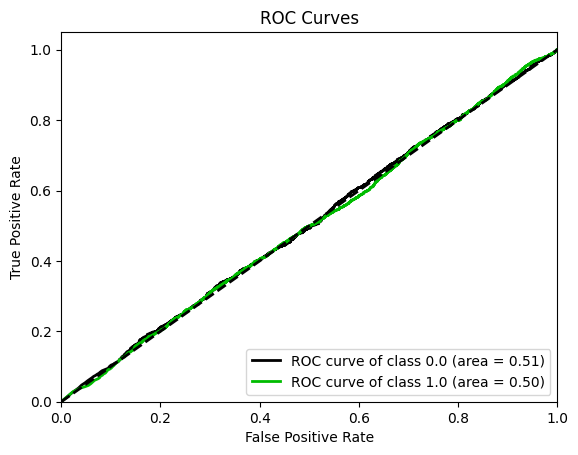

In [ ]:
classification_summary(y_test, ypred, pred, 1)

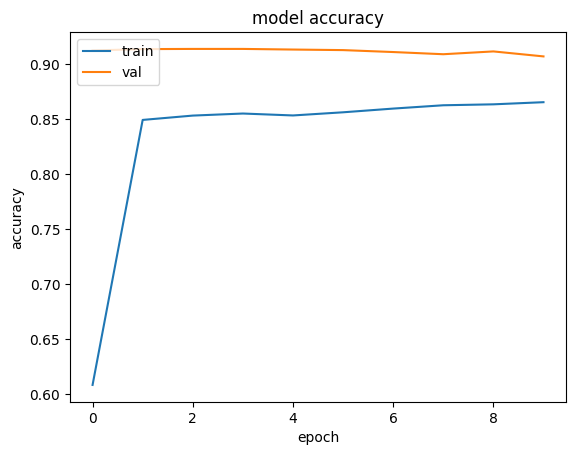

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

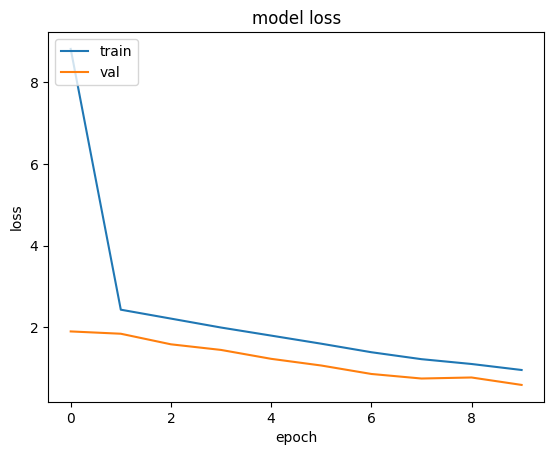

In [ ]:
#plt.plot(figsize=(12,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

## Logistic Regression

In [ ]:
# X = icu_data.drop(['hospital_death'], axis=1)
# y = icu_data['hospital_death']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
#                                                     random_state=11,
#                                                     stratify = y)

## Ajuste de hyperparâmetros

In [ ]:
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

LR_model = LogisticRegression()

# A parameter grid for Logistic Regression
params = dict()
params['solver'] = ['liblinear']
# params['penalty'] = ['l1', 'l2']
# params['C'] = [1,2,3,4,5]


gsearch = GridSearchCV(
    estimator=LR_model,
    param_grid=params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=gkf
)

lr_model = gsearch.fit(X=X_train, y=y_train)
print(lr_model)
(gsearch.best_params_, gsearch.best_score_)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7ae981677760>,
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'solver': ['liblinear']}, scoring='roc_auc')


({'solver': 'liblinear'}, 0.8597503300633725)

## Avaliação do modelo tunado

In [ ]:
lr_tuned = lr_model.best_estimator_.fit(X_train, y_train)

In [ ]:
ypred = lr_tuned.predict(X_test)
pred_prob = lr_tuned.predict_proba(X_test)

In [ ]:
print(pred_prob)

[[0.97317316 0.02682684]
 [0.81238388 0.18761612]
 [0.53840553 0.46159447]
 ...
 [0.96717693 0.03282307]
 [0.92943918 0.07056082]
 [0.92762107 0.07237893]]


<<<--- Avaliando Logistic Regression (LR) --->>>

Accuracy = 92.4%
F1 Score = 90.8%

 Confusuion Matrix:
 [[15884   210]
 [ 1137   393]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     16094
         1.0       0.65      0.26      0.37      1530

    accuracy                           0.92     17624
   macro avg       0.79      0.62      0.66     17624
weighted avg       0.91      0.92      0.91     17624



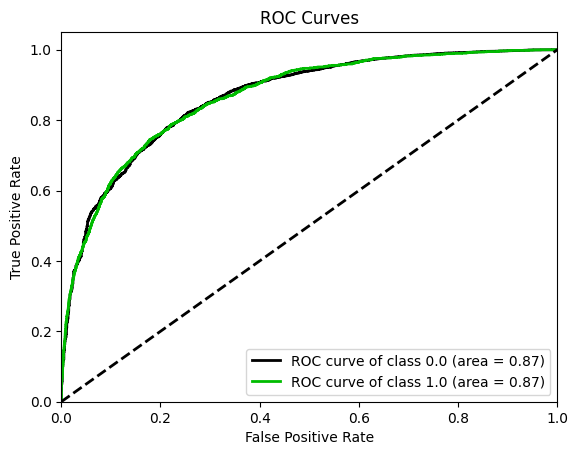

In [ ]:
classification_summary(y_test, ypred, pred_prob, 0)

## **Observações e exercícios:**

- Vimos como é importante compreender os dados do nosso problema, trazendo insights a respeito de todo o pipeline para a tarefa alvo;<br>
<br>
- Neste exemplo não foram empregadas diversas técnicas, como por exemplo, a normalização dos dados, aumento ou diminuição de dados (sub/over-sampling + SMOTE), técnicas de encoding (LabelBinarizer(), LabelEncoder(), OrdinalEncoder()), seleção de atributos, etc;<br>
<br>
- As técnicas previamente citadas podem, e devem, ser utilizadas para mitigar os pontos fracos, como por exemplo colinearidade entre atributos, o desbalanceamento de classes, problema com variáveis categóricas e numéricas, etc;<br>
<br>
- Portanto, precisamos definir de forma assertiva o pipeline da tarefa, a fim de tratar os problemas e construir um modelo robusto e eficaz;<br>
<br>
- Vale ressaltar que nem sempre um modelo complexo é melhor que um mais simples: NN vs.RL.<br>
<br>